# Importing Libraries

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

import re 
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

# Loading DataSet

In [2]:
df = pd.read_csv("NASA.csv")
df.drop(df.columns[[1,2,4,5,6,7,8,9,10,11]], axis=1, inplace=True)
df.rename(columns = {'Unnamed: 0':'Tweet ID'}, inplace = True)
df

,Tweet ID,Tweet
0,0,"Here's to you, Oppy. 🥂\n\nBefore you say #Good..."
1,1,Are there rivers and lakes on other worlds? Yo...
2,2,We want to hear from you!\n\nJoin our series o...
3,3,"The @NASAExoplanets data hint that WASP-39 b, ..."
4,4,.@NASAWebb just scored another first: a full p...
...,...,...
14105,14105,The supermoon is here! Be sure to bundle up th...
14106,14106,Ever wonder how we track supermoons 🌕 and othe...
14107,14107,"A supermoon is coming! Tonight, the full Moon ..."
14108,14108,Happy New Year from space! Astronauts aboard t...


In [3]:
df['len'] = df['Tweet'].str.len()
df

,Tweet ID,Tweet,len
0,0,"Here's to you, Oppy. 🥂\n\nBefore you say #Good...",245
1,1,Are there rivers and lakes on other worlds? Yo...,293
2,2,We want to hear from you!\n\nJoin our series o...,302
3,3,"The @NASAExoplanets data hint that WASP-39 b, ...",175
4,4,.@NASAWebb just scored another first: a full p...,189
...,...,...,...
14105,14105,The supermoon is here! Be sure to bundle up th...,174
14106,14106,Ever wonder how we track supermoons 🌕 and othe...,140
14107,14107,"A supermoon is coming! Tonight, the full Moon ...",255
14108,14108,Happy New Year from space! Astronauts aboard t...,254


In [4]:
df['len'].describe()

count    14110.000000
mean       239.409001
std         75.212052
min          8.000000
25%        208.000000
50%        268.000000
75%        297.000000
max        453.000000
Name: len, dtype: float64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14110 entries, 0 to 14109
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Tweet ID  14110 non-null  int64 
 1   Tweet     14110 non-null  object
 2   len       14110 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 330.8+ KB


# Preprocessing The Data

In [6]:
df.isnull().any()

Tweet ID    False
Tweet       False
len         False
dtype: bool

In [7]:
df['dup'] = df.duplicated(subset=None, keep='first')
del df['dup']


In [8]:
def preprocess1(text):
    text = text.lower()
    return text
df['Tweet'] = df['Tweet'].apply(lambda x: preprocess1(x))

In [9]:
def preprocess2(text):
    html=re.compile(r'<.*?>') 
    text = html.sub(r'',text)
    return text
df['Tweet'] = df['Tweet'].apply(lambda x: preprocess2(x))

In [10]:
def preprocess3(text):
    text = re.sub(r"http\S+", "",text)
    return text
df['Tweet'] = df['Tweet'].apply(lambda x: preprocess3(x))

In [11]:
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df["Tweet"] = df["Tweet"].apply(lambda text: remove_punctuation(text))

In [12]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df["Tweet"] = df["Tweet"].apply(lambda text: remove_stopwords(text))

In [13]:
from collections import Counter
cnt = Counter()
for text in df["Tweet"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('amp', 3136),
 ('spacestation', 3047),
 ('space', 2797),
 ('live', 2182),
 ('et', 2177),
 ('mission', 2151),
 ('watch', 2049),
 ('launch', 1964),
 ('moon', 1816),
 ('spacecraft', 1808)]

In [14]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

df["Tweet"] = df["Tweet"].apply(lambda text: remove_freqwords(text))

In [15]:
n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

df["Tweet"] = df["Tweet"].apply(lambda text: remove_rarewords(text))

In [16]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

df["Tweet"] = df["Tweet"].apply(lambda text: stem_words(text))

In [17]:
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

df["Tweet"] = df["Tweet"].apply(lambda text: lemmatize_words(text))

# Conversion Of Emoji's and EmotIcons in Data

In [18]:
import regex
import emoji
import html.parser as html

emoticons = [':-)', ':)', '(:', '(-:', ':))', '((:', ':-D', ':D', 'X-D', 'XD', 'xD', 'xD', '<3', '</3', ':\*',
                 ';-)',
                 ';)', ';-D', ';D', '(;', '(-;', ':-(', ':(', '(:', '(-:', ':,(', ':\'(', ':"(', ':((', ':D', '=D',
                 '=)',
                 '(=', '=(', ')=', '=-O', 'O-=', ':o', 'o:', 'O:', 'O:', ':-o', 'o-:', ':P', ':p', ':S', ':s', ':@',
                 ':>',
                 ':<', '^_^', '^.^', '>.>', 'T_T', 'T-T', '-.-', '*.*', '~.~', ':*', ':-*', 'xP', 'XP', 'XP', 'Xp',
                 ':-|',
                 ':->', ':-<', '$_$', '8-)', ':-P', ':-p', '=P', '=p', ':*)', '*-*', 'B-)', 'O.o', 'X-(', ')-X']


def split_count(text):
    text = html.unescape(text)
    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI['en'] for char in word):
            emoji_list.append(word)
    for word in text.split(' '):
        if word in emoticons :
            emoji_list.append(word)
    return emoji_list

text = df['Tweet']
emoji_list= [] 
for t in text:
    emoji_list=emoji_list+split_count(t)
    
from collections import Counter
print(Counter(emoji_list))

Counter({'🚀': 906, '✨': 253, '👩\u200d🚀': 173, '🔴': 168, '🛰️': 167, '👨\u200d🚀': 158, '🔥': 151, '🌎': 146, '💫': 140, '🤩': 130, '📸': 104, '📺': 95, '☀️': 92, '✅': 90, '🌟': 90, '👀': 89, '🔭': 84, '🌕': 82, '🤔': 76, '😎': 68, '😍': 67, '🎧': 67, '🐉': 67, '🌌': 65, '☄️': 60, '🌊': 60, '🚨': 50, '✈️': 49, '🌍': 47, '➡️': 44, '🔬': 43, '👋': 41, '🚁': 41, '❓': 40, '🌑': 40, '✔️': 40, '🌔': 39, '🥳': 37, '🔊': 37, '😉': 36, '🤖': 36, '📅': 36, '🔗': 36, '🌖': 34, '🙌': 33, '🎶': 32, '▪️': 32, '🌙': 31, '🌞': 31, '🌒': 31, '⏰': 31, '🤓': 30, '🎙️': 29, '📲': 28, '❤️': 26, '🎉': 25, '🏆': 25, '🎥': 25, '☁️': 24, '📍': 24, '📚': 24, '🌝': 23, '🎙': 23, '🗓️': 23, '❄️': 23, '⭐': 23, '🧪': 22, '🔵': 22, '📷': 21, '🔍': 20, '🧑\u200d🚀': 20, '📱': 20, '💨': 19, '💥': 19, '🎨': 19, '👏': 19, '🌀': 19, '🌠': 19, '🔋': 19, '📡': 18, '💪': 18, '💧': 18, '🛰': 17, '🌱': 17, '🏈': 17, '⭐️': 17, '🪐': 16, '💻': 16, '🌏': 16, '⬇️': 16, '👉': 16, '🗳️': 14, '⚪️': 14, '🕒': 14, '🎃': 13, '🖖': 13, '👩🏽\u200d🚀': 13, '⚙️': 13, '💙': 12, '😱': 12, '👍': 12, '⚫': 12, '🌃': 12, '🌚': 12

In [19]:
import re
from emot.emo_unicode import UNICODE_EMOJI
def convert_emojis(text):
    for emot in UNICODE_EMOJI:
        text = text.replace(emot, "_".join(UNICODE_EMOJI[emot].replace(",","").replace(":","").split()))
    return text

df['Tweet'] = df['Tweet'].apply(lambda x: convert_emojis(x))
df

,Tweet ID,Tweet,len
0,0,here oppi clinking_glasses say goodnightoppi l...,245
1,1,river lake world bet like earth saturn’ titan ...,293
2,2,want hear join seri virtual inperson meet seek...,302
3,3,nasaexoplanet data hint wasp39 b aka bocaprin ...,175
4,4,nasawebb score anoth first full profil atom mo...,189
...,...,...,...
14105,14105,supermoon sure bundl lead outsid view wolf sup...,174
14106,14106,ever wonder track supermoon full_moon lunar ev...,140
14107,14107,supermoon come tonight full near close point o...,255
14108,14108,happi new year astronaut aboard share memori r...,254


# Adding Labels

In [20]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sentiments = SentimentIntensityAnalyzer()
df["Positive"] = [sentiments.polarity_scores(i)["pos"] for i in df["Tweet"]]
df["Negative"] = [sentiments.polarity_scores(i)["neg"] for i in df["Tweet"]]
df['Compound'] = [sentiments.polarity_scores(i)["compound"] for i in df["Tweet"]]
score = df["Compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append(1)
    else:
        sentiment.append(0)
df['Sentiment'] = sentiment
df.head()



,Tweet ID,Tweet,len,Positive,Negative,Compound,Sentiment
0,0,here oppi clinking_glasses say goodnightoppi l...,245,0.000,0.0,0.0000,0
1,1,river lake world bet like earth saturn’ titan ...,293,0.094,0.0,0.3612,1
2,2,want hear join seri virtual inperson meet seek...,302,0.137,0.0,0.3612,1
3,3,nasaexoplanet data hint wasp39 b aka bocaprin ...,175,0.000,0.0,0.0000,0
4,4,nasawebb score anoth first full profil atom mo...,189,0.000,0.0,0.0000,0


In [21]:
df.drop(df.columns[[3,4,5]], axis=1, inplace=True)
df


,Tweet ID,Tweet,len,Sentiment
0,0,here oppi clinking_glasses say goodnightoppi l...,245,0
1,1,river lake world bet like earth saturn’ titan ...,293,1
2,2,want hear join seri virtual inperson meet seek...,302,1
3,3,nasaexoplanet data hint wasp39 b aka bocaprin ...,175,0
4,4,nasawebb score anoth first full profil atom mo...,189,0
...,...,...,...,...
14105,14105,supermoon sure bundl lead outsid view wolf sup...,174,1
14106,14106,ever wonder track supermoon full_moon lunar ev...,140,0
14107,14107,supermoon come tonight full near close point o...,255,0
14108,14108,happi new year astronaut aboard share memori r...,254,1


# Data Visualization

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 30')

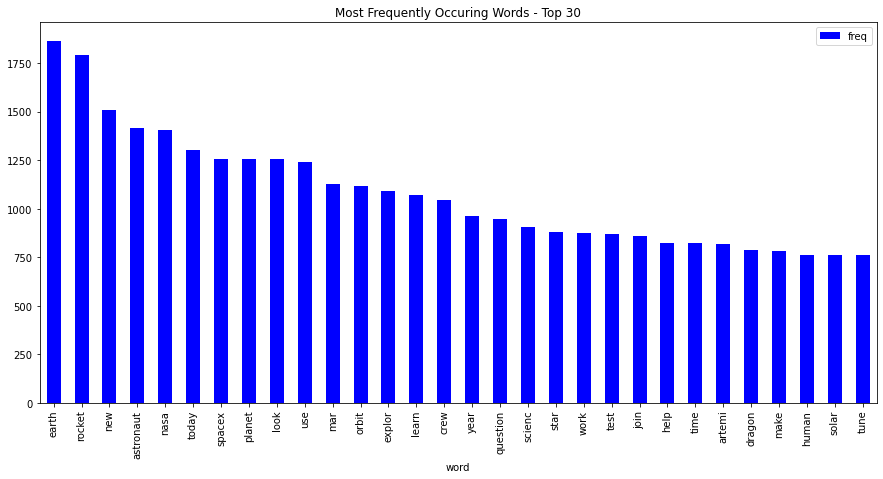

In [22]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.Tweet)

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 30")


Text(0.5, 1.0, 'WordCloud - Vocabulary from NASA.csv')

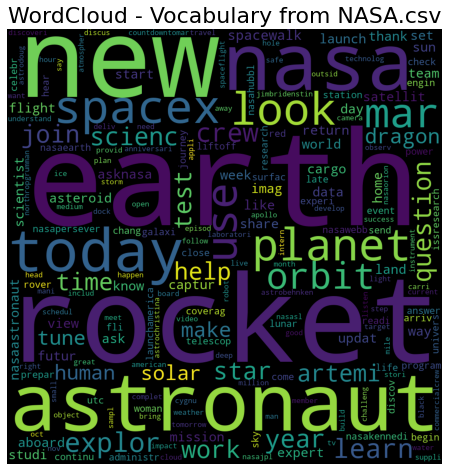

In [23]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 1000, height = 1000).generate_from_frequencies(dict(words_freq))

plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title("WordCloud - Vocabulary from NASA.csv", fontsize = 22)

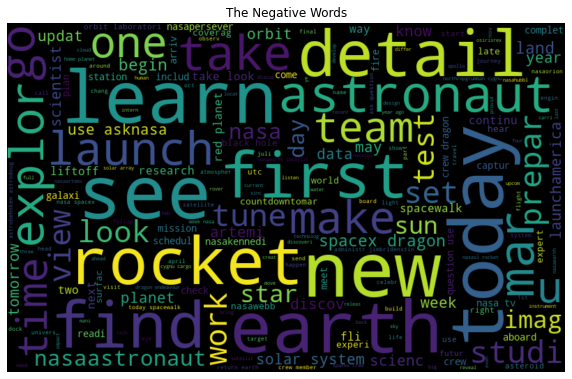

In [24]:
negative_words =' '.join([text for text in df['Tweet'][df['Sentiment'] == 0]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(negative_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Negative Words')
plt.show()

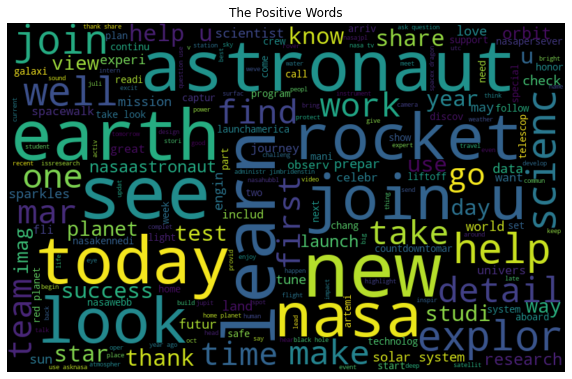

In [25]:
positive_words =' '.join([text for text in df['Tweet'][df['Sentiment'] == 1]])

wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size = 110).generate(positive_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('The Positive Words')
plt.show()

# Splitting The Data

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_df=0.90,min_df=2,max_features = 2500,stop_words='english')
x = cv.fit_transform(df['Tweet'])

In [27]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(x,df['Sentiment'],test_size=0.3)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
model = LogisticRegression()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

print("accuracy_score",accuracy_score(y_test,y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

accuracy_score 0.9102291519017246
Confusion Matrix
[[2131  116]
 [ 264 1722]]


In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("accuracy_score",accuracy_score(y_test,y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

accuracy_score 0.9364516891093787
Confusion Matrix
[[2152   95]
 [ 174 1812]]


In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("accuracy_score",accuracy_score(y_test,y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

accuracy_score 0.9192062367115521
Confusion Matrix
[[2075  172]
 [ 170 1816]]


In [31]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("accuracy_score",accuracy_score(y_test,y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

accuracy_score 0.9267658870777227
Confusion Matrix
[[2165   82]
 [ 228 1758]]
